# Demo of *custom_nn.py*

In [1]:
import struct
import array
import gzip
import numpy as np
from matplotlib import pyplot as plt
import PIL.Image
from custom_nn import MultilayerPerceptronNN, prepare, train, accuracy

## Training and testing with the MNIST database

In [2]:
DATA_TYPES = {0x08: 'B',  # unsigned byte
              0x09: 'b',  # signed byte
              0x0b: 'h',  # short (2 bytes)
              0x0c: 'i',  # int (4 bytes)
              0x0d: 'f',  # float (4 bytes)
              0x0e: 'd'}  # double (8 bytes)


def get_mnist_data_from_file(filename):
    with open(filename, "rb") as f:
        content = f.read()
    data_bytes = gzip.decompress(content)
    zeros, dtype, n_dim = struct.unpack('>HBB', data_bytes[:4])
    dim_sizes = struct.unpack('>'+'I'*n_dim, data_bytes[4:4+4*n_dim])
    data = array.array(DATA_TYPES[dtype], data_bytes[4+4*n_dim:])
    return np.array(data).reshape(dim_sizes)

path = '../mnist_database/'
train_images = get_mnist_data_from_file(path + 'train-images-idx3-ubyte.gz')
train_labels = get_mnist_data_from_file(path + 'train-labels-idx1-ubyte.gz')
test_images = get_mnist_data_from_file(path + 't10k-images-idx3-ubyte.gz')
test_labels = get_mnist_data_from_file(path + 't10k-labels-idx1-ubyte.gz')

In [3]:
data = prepare(train_images, train_labels, p_validation=0.2)
nn_model = MultilayerPerceptronNN((784, 128, 32, 10))
train_log = train(nn_model, data, n_epoch=100, batch_size=256, lr0=0.01, decay_rate=1)

Total iterarions: 18750
Iteration 0/18750 (epoch 0) ; loss=2.3854437728815165 ; vloss=2.3619837604053284
Iteration 100/18750 (epoch 0) ; loss=0.8941278753548789 ; vloss=0.8755512093760015
Iteration 200/18750 (epoch 1) ; loss=0.3510808460230492 ; vloss=0.382650820684669
Iteration 300/18750 (epoch 1) ; loss=0.34038433562927367 ; vloss=0.31748393073087133
Iteration 400/18750 (epoch 2) ; loss=0.26405909630740354 ; vloss=0.2828836817455082
Iteration 500/18750 (epoch 2) ; loss=0.25057205383725356 ; vloss=0.2615115740287229
Iteration 600/18750 (epoch 3) ; loss=0.17524413650250348 ; vloss=0.24478652477031673
Iteration 700/18750 (epoch 3) ; loss=0.1948545707006433 ; vloss=0.23553730030679165
Iteration 800/18750 (epoch 4) ; loss=0.2075463944875826 ; vloss=0.22153009858742195
Iteration 900/18750 (epoch 4) ; loss=0.22224264162156712 ; vloss=0.21403050483855152
Iteration 1000/18750 (epoch 5) ; loss=0.15410523791853042 ; vloss=0.20820523344911065
Iteration 1100/18750 (epoch 5) ; loss=0.2008151901839

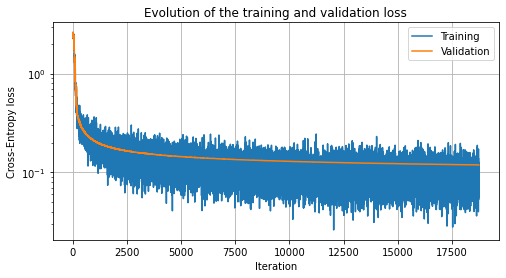

In [4]:
def plot_loss(loss_train, loss_val):
    plt.figure(figsize=(8, 4))
    plt.plot(loss_train, '-', label="Training")
    plt.plot(loss_val, '-', label="Validation")
    plt.title("Evolution of the training and validation loss")
    plt.yscale('log')
    plt.xlabel("Iteration")
    plt.ylabel("Cross-Entropy loss")
    plt.legend()
    plt.grid()

plot_loss(train_log['loss'], train_log['vloss'])
plt.show()

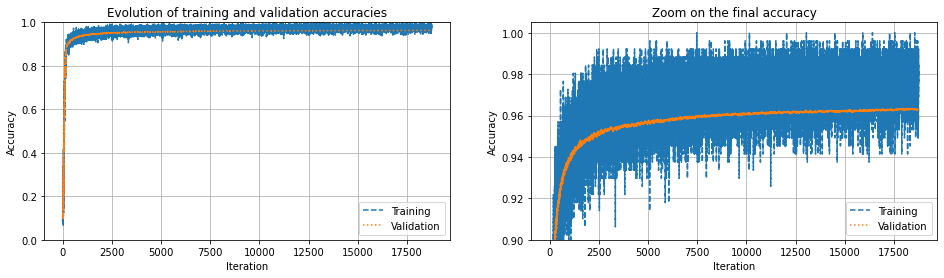

In [5]:
def plot_accuracy(acc_train, acc_val, zoom=(0.90, 1.005)):
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1,2,1)
    plt.plot(acc_train, '--', label="Training")
    plt.plot(acc_val,':', label="Validation")
    plt.ylim(0, 1)
    plt.title("Evolution of training and validation accuracies")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(acc_train, '--', label="Training")
    plt.plot(acc_val,':', label="Validation")
    plt.ylim(zoom[0], zoom[1])
    plt.title("Zoom on the final accuracy")
    plt.xlabel("Iteration")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

plot_accuracy(train_log['acc'], train_log['vacc'])
plt.show()

Overall accuracy: 0.9654
Class 0 accuracy: 0.98673
Class 1 accuracy: 0.9859
Class 2 accuracy: 0.96512
Class 3 accuracy: 0.97624
Class 4 accuracy: 0.96334
Class 5 accuracy: 0.94395
Class 6 accuracy: 0.9666
Class 7 accuracy: 0.96109
Class 8 accuracy: 0.95893
Class 9 accuracy: 0.94153


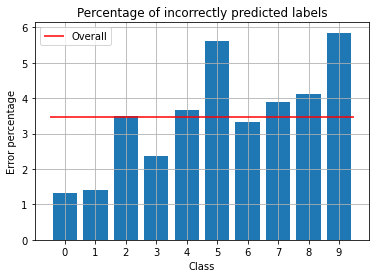

In [6]:
def accuracy_per_class(pred, labels, k):
    sum_per_class = np.array([(labels == i).sum() for i in range(k)])
    sum_correct_per_class = np.array([((labels == i) & (pred == i)).sum() for i in range(k)])
    return sum_correct_per_class / sum_per_class

test_data = prepare(test_images, test_labels, p_validation=0)
y_pred, _ = nn_model.forward(test_data[0])
pred_digits = np.argmax(y_pred, axis=0)

acc_per_class = accuracy_per_class(pred_digits, test_data[1], k=10)
acc_overall = (pred_digits == test_data[1]).mean()
print('Overall accuracy:', acc_overall)
for i in range(10):
    print(f"Class {i} accuracy: {acc_per_class[i].round(5)}")
    
error_per_class = 100 * (1 - acc_per_class)
error_overall = 100 * (1 - acc_overall)
plt.bar(range(10), error_per_class)
plt.title('Percentage of incorrectly predicted labels')
plt.xlabel('Class')
plt.ylabel('Error percentage')
plt.xticks(range(10))
plt.hlines(error_overall, -.5, 9.5, color='r', label='Overall')
plt.legend()
plt.grid()

## Test on custom images

In [7]:
imgs = [PIL.Image.open(f'./my_handwritten_digits/digit{i}.jpg') for i in range(10)]

def prepare_test_images(imgs):
    x = [img.resize((28, 28)) for img in imgs]
    x = 255 - np.stack([np.array(img) for img in x]).mean(axis=3)
    x = x.reshape((-1, 28*28))
    x_min = x.min(axis=1).reshape((-1, 1))
    x_max = x.max(axis=1).reshape((-1, 1))
    x_range = (x_max - x_min) + (x_max == x_min)
    x = (x - x_min) / x_range
    x *= x > 1.0*(x.mean(axis=1).reshape(-1,1))
    return x.T

def show_test_results(model, imgs):
    inp = prepare_test_images(imgs)
    y_pred, _ = model.forward(inp)
    digits_pred = np.argmax(y_pred, axis=0)
    for i, img in enumerate(imgs):
        plt.figure(figsize=(12,5))
        plt.subplot(131)
        plt.title('Initilal RGB image')
        plt.imshow(img)
        plt.xticks([]) ; plt.yticks([])
        plt.subplot(132)
        plt.title('Grayscale image resized to 28x28\n(background noise removed)')
        plt.imshow(inp.T[i].reshape(28,28), 'Greys')
        plt.xticks([]) ; plt.yticks([])
        plt.subplot(133)
        plt.bar(range(10), y_pred.T[i])
        plt.xticks(range(10))
        plt.ylim(0, 1)
        plt.xlim(-.5, 9.5)
        plt.grid(axis='y')
        plt.xlabel('output values')
        plt.title(f'Predicted digit = {digits_pred[i]}')
    plt.show()

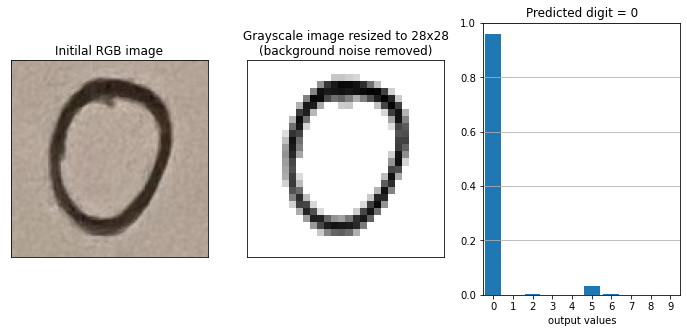

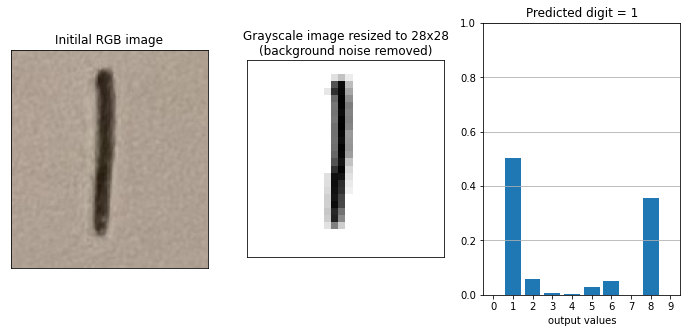

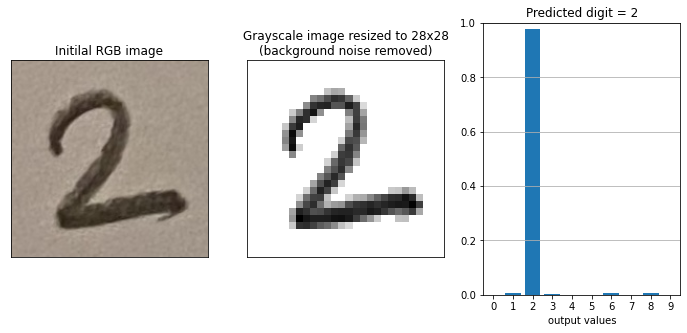

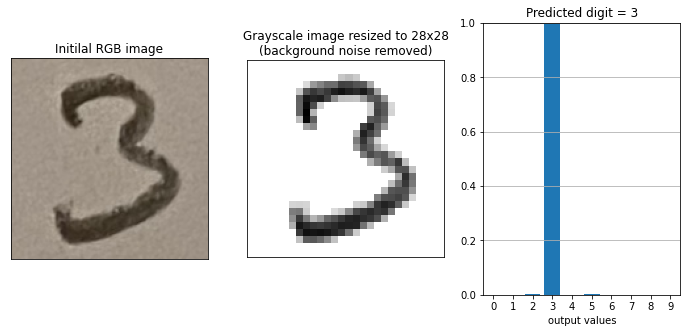

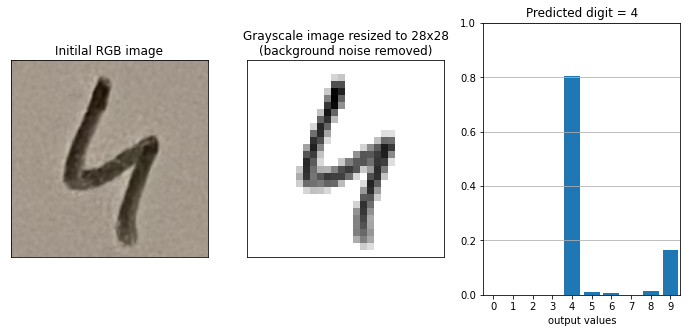

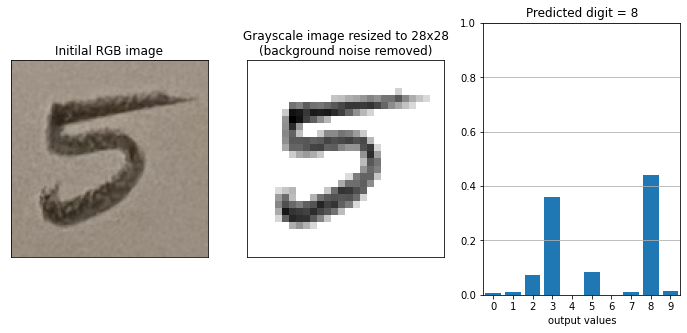

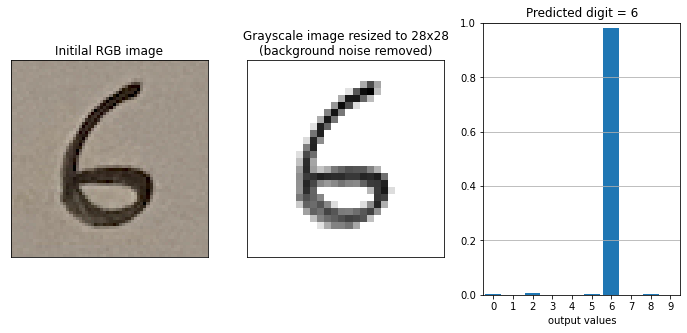

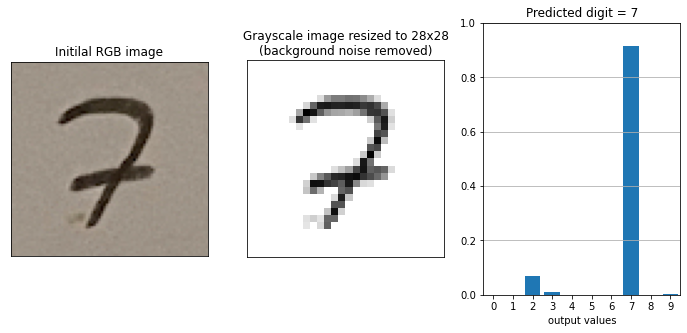

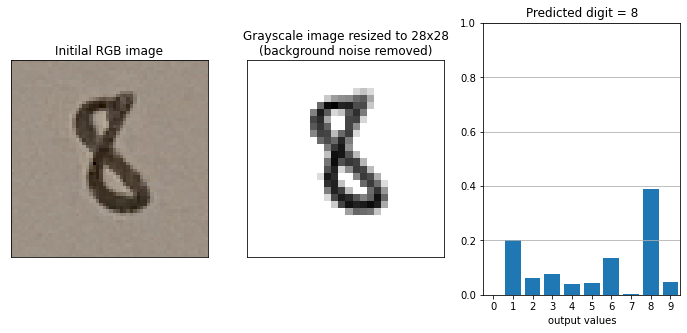

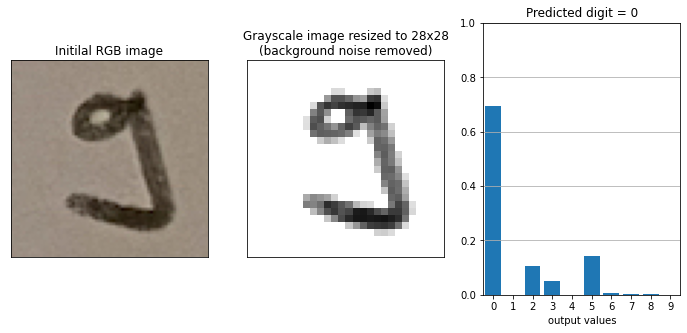

In [8]:
show_test_results(nn_model, imgs)

**Comment:** <br>
The two wrongly predicted digits, "5" and "9", are the ones for which the error percentage are the highest on the MNIST test set.

## Testing the backpropagation of the gradient

In [9]:
from custom_nn import one_hot, ce_loss


def test_gradient_coherence():
    model = MultilayerPerceptronNN((784, 256, 64, 32, 16, 10))
    data = prepare(train_images, train_labels, p_validation=0)
    inputs, labels, _, _ = data
    random_inp_idx = np.random.randint(inputs.shape[1])
    inp = inputs[:, random_inp_idx:random_inp_idx+1]
    targ = one_hot(labels[random_inp_idx:random_inp_idx+1])
    y, hidden = model.forward(inp)
    dw = model.backprop(hidden, y, targ)
    
    epsilon_values = np.logspace(-7, 2, base=10)
    grad_errors = []
    for i in range(len(model.dim)-1):
        p = np.random.randint(0, model.w[i].shape[0])
        q = np.random.randint(0, model.w[i].shape[1])
        wi_pq_init_value = model.w[i][p, q]
        dw_approx_all = []
        for epsilon in epsilon_values:
            model.w[i][p, q] = wi_pq_init_value + epsilon
            y_plus_eps, _ = model.forward(inp)
            model.w[i][p, q] = wi_pq_init_value - epsilon
            y_minus_eps, _ = model.forward(inp)
            dw_approx = (ce_loss(y_plus_eps, targ) - ce_loss(y_minus_eps, targ)) / (2 * epsilon)
            dw_approx_all.append(dw_approx)
            model.w[i][p, q] = wi_pq_init_value
        dw_approx_all = np.array(dw_approx_all)
        w_info = f'w[{i}][{p},{q}]'
        grad_errors = np.abs(dw_approx_all - dw[i][p, q])
        plt.loglog(epsilon_values, grad_errors, '.-', label=w_info)
    plt.title('Error of gradient approximation (2nd order finite difference)')
    plt.xlabel('epsilon')
    plt.ylabel('L1 error')
    plt.legend()
    plt.grid()

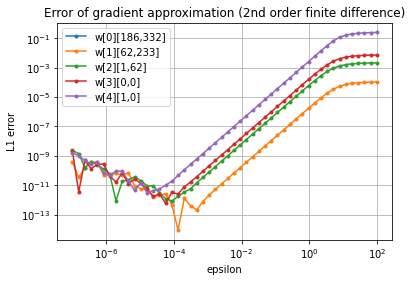

In [10]:
test_gradient_coherence()

**Comment:** <br>
For epsilon values which are not too large nor excessively small, the error decreases by -20 dB/decade as epsilon decreases, which is coherent the error of 2nd order finite difference for approximating gradients. This does not disprove that gradients are incorrectly computed during backpropagation. So we can be confident that the backpropagation is correctly computed. <br>
Note that if some weights are inactive, then the gradient will be null for those weights, so it will not be shown on the graph.